In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


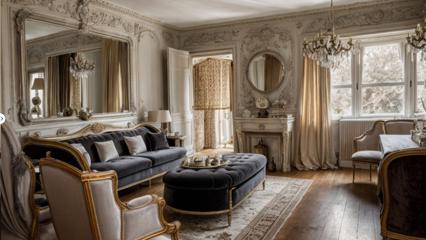

[Using Gepetto to decorate your apartment.](https://www.cnet.com/tech/services-and-software/all-i-wanted-was-a-new-couch-but-ai-gave-my-living-room-a-versailles-makeover/) - CNET

___

[A review of research on mental health chatbots (although they have evolved so fast recently that older ones may not be very relevant)](https://www.htworld.co.uk/news/mental-health/chatbots-show-potential-to-bridge-gaps-in-mental-health-services/)

___

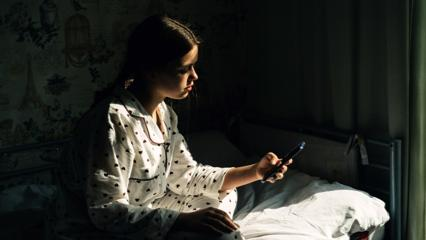

[More people are turning to mental health AI chatbots. What could go wrong?](https://www.nationalgeographic.com/science/article/ai-chatbots-treatment-mental-health) - Science

___

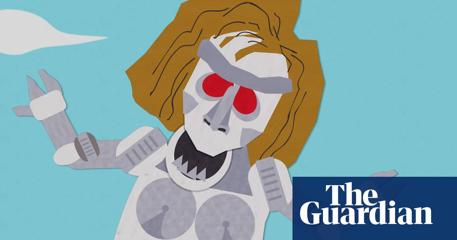

[AI is ruining everything, Hollywood edition](https://www.theguardian.com/tv-and-radio/article/2024/jul/05/the-disruption-is-already-happening-is-ai-about-to-ruin-your-favourite-tv-show) - the Guardian

___

[AI for retirees: smart homes, personalized health care, mental health, VR experiences, automating finances.](https://www.thestreet.com/retirement-daily/planning-living-retirement/how-ai-is-revolutionizing-retirement-live-your-best-life)

___

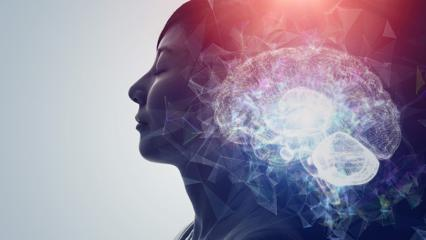

[AI listens to sessions, helps therapists with note-taking and paperwork.](https://www.zdnet.com/article/ai-is-relieving-therapists-from-burnout-heres-how-its-changing-mental-health/) - ZDNET

___

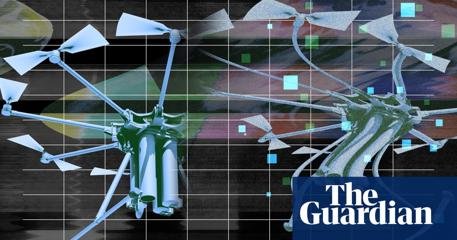

[An Oppenheimer moment as AI weapons take over.](https://www.theguardian.com/technology/article/2024/jul/14/ais-oppenheimer-moment-autonomous-weapons-enter-the-battlefield) - the Guardian

___

[Samsung ships sketch to image, which turns your doodles into art in different styles.](https://x.com/zan2434/status/1811122856421642537) - X (formerly Twitter)

___

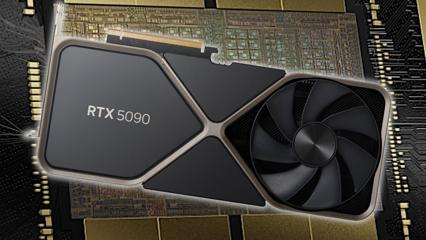

[Some discussion of Nvidia 5090s, between new architecture, more RAM, wider bus, new process node, should be another big jump.](https://evrimagaci.org/tpg/nvidias-bold-moves-in-ai-and-gpu-compel-attention-389) - The Pinnacle Gazette

___

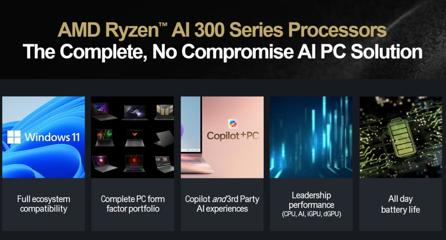

[AMD details AI chips. I feel like, until there is a cross-platform CUDA-type layer (which I know people are working on), will be hard for software to use NPUs across AMD, Intel, ARM chips, people will have to access AI services through the OS layer.](https://venturebeat.com/ai/amd-takes-a-deep-dive-into-architecture-for-the-ai-pc-chips/) - VentureBeat

___

[Is ‘symbiocidal’ a word?](https://www.reddit.com/r/ChatGPT/s/oF8jqrg0da)

___

More science- and data-driven choices sound great, but whose data, whose science, and to maximize what exactly?

[Fake insight and empathy seems like it could do more harm than good.](https://www.psypost.org/new-paper-explores-the-blurred-lines-between-ai-and-human-communication/)

___

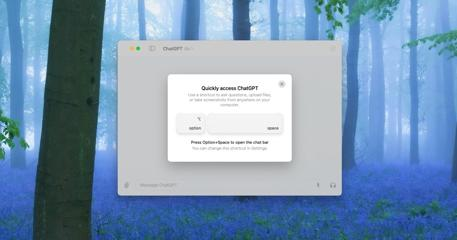

[Using the native Mac ChatGPT app with all your files, images, emails and voice. Not as fully integrated as AI probably will be soon, but it’s a start](https://www.digitaltrends.com/computing/3-things-i-love-about-chatgpt-mac-app/) - Digital Trends

___

[Check GPT inserts a disclaimer when asked about this weekend’s events.](https://www.reddit.com/r/ChatGPT/comments/1e3fjpl/chatgpt_puts_this_little_notice_when_you_ask_it/)

___

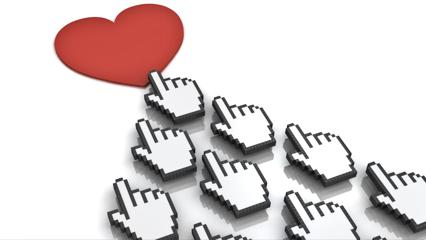

[Psychology and romantic chatbots.](https://www.livescience.com/health/relationships/people-are-falling-in-love-with-ai-should-we-worry) - livescience.com

___

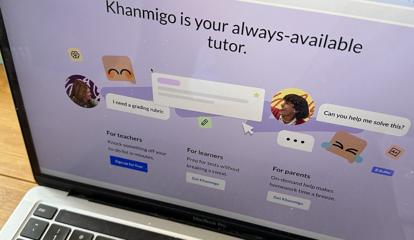

[Khanmigo lets you chat with Lady Macbeth](https://newhampshirebulletin.com/2024/07/15/from-precalculus-to-gatsby-state-offers-schools-an-ai-tutor-option/) - New Hampshire Bulletin

___

[Will AI be your assistant or your boss?](https://www.fastcompany.com/91153187/will-ai-become-your-assistant-or-your-boss-an-ethicist-explains)

___

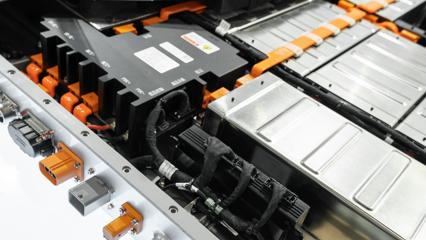

[LG designs better custom batteries faster with AI.](https://interestingengineering.com/energy/lg-energy-solution-ai-battery-designing) - Interesting Engineering

___

[Nudges from your AI health coach vs. nudges from your employer or insurer, vs markets and policies](https://theconversation.com/why-an-ai-health-coach-wont-solve-the-worlds-chronic-disease-problems-234369)

___

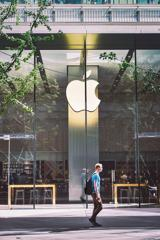

[Dean of stock valuation says market is in danger zone](https://sg.finance.yahoo.com/news/apple-inc-nasdaq-aapl-aswath-214249845.html) - Yahoo Finance

___

[Nice game, congrats to Spain, pretty well deserved
dubz.co/v/ad191b 
dubz.co/v/2c4b47
dubz.co/v/f6f8f9 (barely onside)
dubz.co/v/722c00](https://dubz.co/v/ad191b)

___

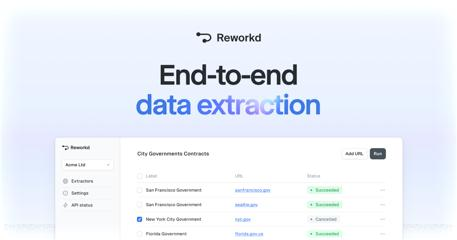

[Cloud data extraction FTW - www.reworkd.ai](https://www.reworkd.ai/)

___

damn that big X is looking even more swastika-like today

[Animals eating noodles](https://twitter.com/_akhaliq/status/1812573686152450397) - X (formerly Twitter)

___

If the shooter had a proper self-directed facial recognition AI robot gun or an autonomous killer drone he wouldn't have missed.

[AI and tech are reshaping warfare.](https://www.axios.com/2024/07/10/us-military-future-weapons-ai-warfare)

___

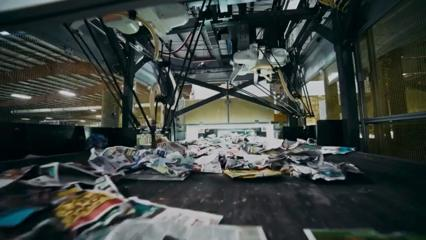

[AI trash sorting. I honestly need an AI app to figure out what to do with different types of trash. I fail  at the Turing Test of, is this Whole Foods carton compost, too dirty for paper bin?](https://www.13newsnow.com/article/news/local/mycity/portsmouth/artificial-intelligence-is-changing-how-the-city-of-portsmouth-recycles/291-770d039e-f053-4336-a9db-cc2e495abbf9) - 13newsnow.com

___

[A beginners' guide to quantization.](https://www.theregister.com/2024/07/14/quantization_llm_feature/)

___

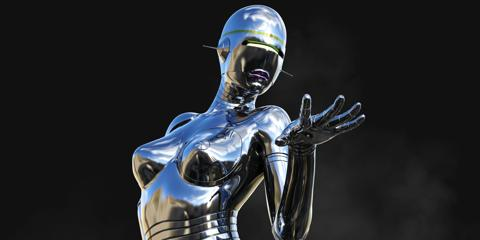

[AskMen survey says everyone is sexting with AI but finding a real person to sext with is proposed as better for both one's sex life and the environment.](https://www.askmen.com/news/dating-news/survey-finds-huge-percentage-of-people-sexting-with-ai.html) - AskMen

___

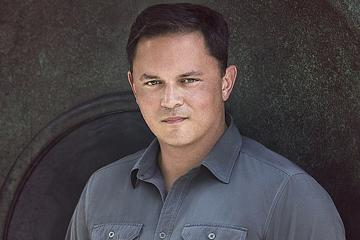

[AI and killer robots figure in new 'Gray Man' novel.](https://www.timesfreepress.com/news/2024/jul/13/review-mark-greaneys-gray-man-tackles-a-new-foe/)

___

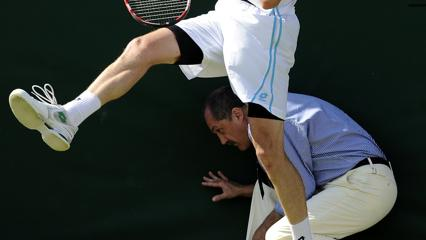

[Wimbledon line judges might be replaced by AI, Djokovic says it's time.](https://www.dailymail.co.uk/news/article-13631915/Wimbledon-line-judges-fear-usurped-artificial-intelligence-SW19-French-Open-two-grand-slam-tournaments-adopt-electronic-line-calling-system.html) - Mail Online

___

[Using LMSYS type Chatbot Arena battles to train and improve chatbots.](https://www.microsoft.com/en-us/research/publication/arena-learning-build-data-flywheel-for-llms-post-training-via-simulated-chatbot-arena/)

___

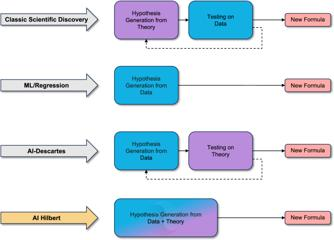

[Open source AI Hilbert combines data and theory to formulate testable hypotheses and advance science - ai-hilbert.github.io](https://www.nature.com/articles/s41467-024-50074-w) - Nature

___

[How Microsoft’s Satya Nadella Became Tech’s Steely Eyed A.I. Gambler](https://www.nytimes.com/2024/07/14/technology/microsoft-ai-satya-nadella.html)

___

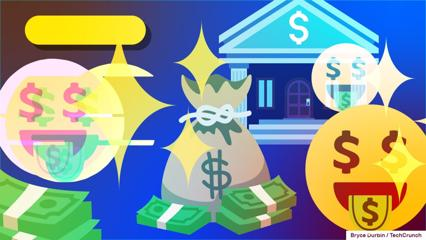

[28 AI startups that raised over \\$100m this year.](https://techcrunch.com/2024/07/13/heres-the-full-list-of-28-us-ai-startups-that-have-raised-100m-or-more-in-2024/) - TechCrunch

___

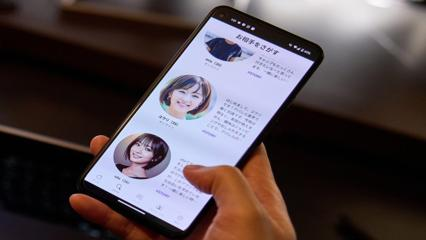

[Loverse AI dating experience app gains popularity in Japan.](https://interestingengineering.com/culture/japan-ai-dating-app-bot-partners) - Interesting Engineering

___

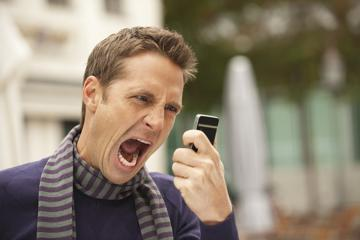

[Surveys say people hate AI customer service.](https://futurism.com/the-byte/people-hate-ai-customer-service) - Futurism

___

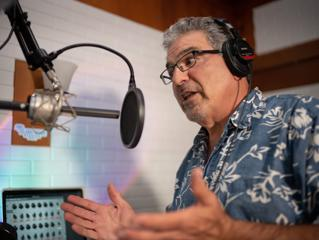

["In a world where AI has replaced voice-over artists like 'voice of God' Don LaFontaine ..."](https://lookout.co/artificial-intelligence-ai-dean-compoginis-voice-over-artist-sounds-alarm/) - Lookout Santa Cruz

___

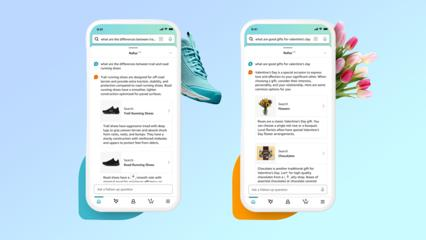

[Amazon's Rufus chatbot is here for Prime Day, reviews say it's OK.](https://www.tomsguide.com/ai/amazons-ai-chatbot-is-here-to-make-prime-day-shopping-easier) - Tom's Guide

___

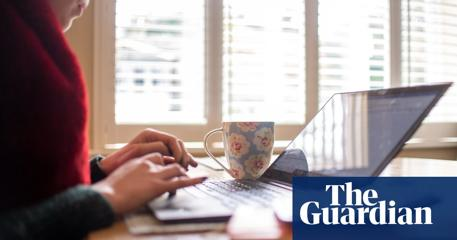

[AI can boost individual writers' creativity while reducing overall novelty and making all writers sound more similar.](https://www.theguardian.com/technology/article/2024/jul/12/ai-prompts-can-boost-writers-creativity-but-result-in-similar-stories-study-finds) - the Guardian

___

Biden be like, damn I can’t catch a break. Why can’t I get grazed in an ear or if they’re gonna shoot at TFG then why can’t they shoot straight? Why do I go to church like every single day? and this is what I get? Why does God hate me so much?

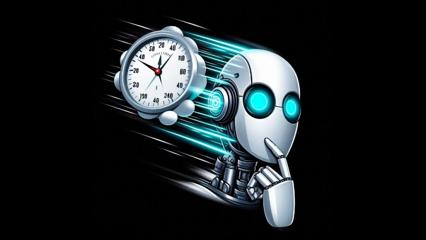

[It feels like LLMs are the fast 'system 1' in Kahneman's 'Thinking Fast and Slow' and the planning and reasoning is the slow 'system 2', and there is this natural dichotomy between the 2, between poets and quants.](https://venturebeat.com/ai/meta-researchers-distill-system-2-thinking-into-llms-improving-performance-on-complex-reasoning/) - VentureBeat

___

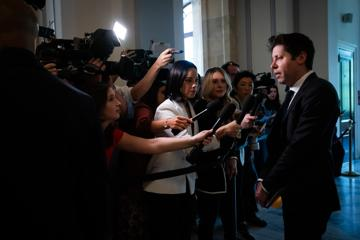

[Whistleblowers say OpenAI illegally barred staffers from whistleblowing.](https://www.washingtonpost.com/technology/2024/07/13/openai-safety-risks-whistleblower-sec/) - Washington Post

___

[Looks like maybe OpenAI is doing a small model or something.](https://x.com/apples_jimmy/status/1812029979888439525) - X (formerly Twitter)

___

A problem in the bullish iPhone thesis is, they will announce in the fall but the AI features might not be available until the spring, by which time 2026 iPhones are 6 months away.

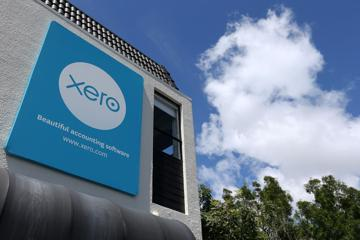

[AI is coming for accounting and financial management but maybe not yet.](https://www.forbes.com/sites/quickerbettertech/2024/07/12/how-intuit-xero-sage-and-sap-are-positioning-ai-to-change-your-accounting-department/) - Forbes

___

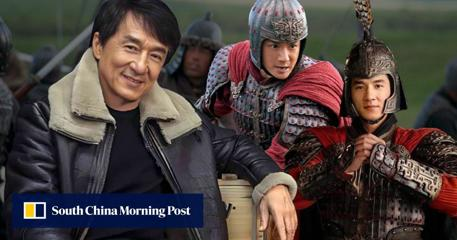

[China audiences mock AI rejuvenation of Jackie Chan.](https://www.scmp.com/news/people-culture/china-personalities/article/3270226/china-critics-pan-ai-rejuvenation-jackie-chan-new-film-legend) - South China Morning Post

___

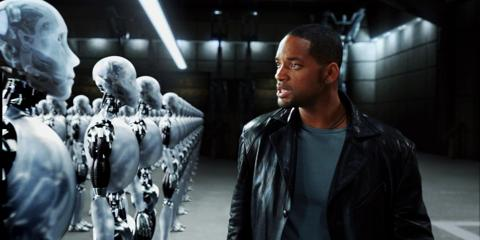

[Is the AI bubble about to burst in Hollywood? I think some uses of AI are like 3D TVs and make things no better and possibly worse, and you have to stay human-centered. On the whole though, giving computers the power of natural language understanding and human speech is kind of a big deal.](https://nofilmschool.com/ai-bubble-burst) - No Film School

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 15, 19, 19, 1, 596000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-14 09:24:47.203151


In [13]:
sqlite

NameError: name 'sqlite' is not defined